In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

## Data Loader

In [2]:
df_ny = pd.read_csv('../data/processed/ny.csv')
df_aus = pd.read_csv('../data/processed/austin.csv')
df = pd.read_csv('../data/processed/combined_data.csv')

# Display the combined DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26200 entries, 0 to 26199
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          26200 non-null  object 
 1   grid          26200 non-null  float64
 2   bathroom      26200 non-null  float64
 3   bedroom       26200 non-null  float64
 4   car           26200 non-null  float64
 5   diningroom    26200 non-null  float64
 6   livingroom    26200 non-null  float64
 7   office        26200 non-null  float64
 8   utilityroom   26200 non-null  float64
 9   waterheater   26200 non-null  float64
 10  aircomp       26200 non-null  float64
 11  kitchenArea   26200 non-null  float64
 12  washer_dryer  26200 non-null  float64
 13  other         26200 non-null  float64
 14  day           26200 non-null  object 
 15  month         26200 non-null  object 
 16  day_name      26200 non-null  object 
 17  hour          26200 non-null  int64  
 18  minute        26200 non-nu

# Convert to Hourly

In [3]:
# Ensure the 'date' column is datetime
df['date'] = pd.to_datetime(df['date'])

# Round the 'date' column to the nearest hour
df['date_hour'] = df['date'].dt.floor('H')

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(exclude='number').columns

# Define aggregation functions for each column
agg_dict = {col: 'mean' for col in numerical_cols}
agg_dict.update({col: 'first' for col in categorical_cols})

# Remove the duplicate `date_hour` column in the aggregation result
agg_dict.pop('date_hour', None)

# Group by the rounded hour and apply the aggregation functions
hourly_df = df.groupby('date_hour').agg(agg_dict).reset_index()

# Display the resulting DataFrame
hourly_df.head()

/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_20259/2254170679.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['date_hour'] = df['date'].dt.floor('H')


,date_hour,grid,bathroom,bedroom,car,diningroom,livingroom,office,utilityroom,waterheater,...,pres,date,day,month,day_name,time_of_day,is_weekend,season,is_holiday,city
0,2018-01-01 06:00:00+00:00,1.529774,0.019875,0.038042,0.002927,0.0,0.029521,0.008906,0.0,0.000948,...,1038.4,2018-01-01 06:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
1,2018-01-01 07:00:00+00:00,1.783868,0.002219,0.013792,0.002396,0.0,0.010083,0.006063,0.0,0.019958,...,1038.3,2018-01-01 07:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
2,2018-01-01 08:00:00+00:00,1.463260,0.004700,0.057340,0.000040,0.0,0.016540,0.007830,0.0,0.000400,...,1038.7,2018-01-01 08:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
3,2018-01-01 09:00:00+00:00,1.449272,0.004630,0.053610,-0.000010,0.0,0.016580,0.009370,0.0,0.000370,...,1039.5,2018-01-01 09:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
4,2018-01-01 10:00:00+00:00,1.443978,0.004590,0.051430,0.000050,0.0,0.016340,0.010560,0.0,0.000370,...,1039.9,2018-01-01 10:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin


# Outlier Detection - Isolation Forest

In [4]:
# Function to detect outliers for multiple columns using Isolation Forest
def detect_outliers(df, columns, contamination=0.05, random_state=42):
    for column in columns:
        # Drop missing values and filter out rows where the appliance usage is 0
        df_col = df[[column]].dropna()
        df_col = df_col[df_col[column] > 0]  # Optional: exclude zero values if necessary
        
        # Initialize Isolation Forest for the column
        iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
        iso_forest.fit(df_col)
        
        # Predict anomalies (outliers = -1, normal = 1)
        df_col['anomaly'] = iso_forest.predict(df_col)
        
        # Add the outlier column back to the original dataframe
        df[f'{column}_outlier'] = np.nan
        df.loc[df_col.index, f'{column}_outlier'] = (df_col['anomaly'] == -1).astype(int)
    
    return df

# Function to visualize the outliers for multiple columns
def visualize_outliers_multi(df, columns, x_axis='hour'):
    num_cols = len(columns)
    
    # Create subplots, one row per column, sharing the x-axis
    fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(12, 2 * num_cols), sharex=True)

    for i, column in enumerate(columns):
        # Check if outlier column exists
        if f'{column}_outlier' not in df.columns:
            print(f"Outlier column '{column}_outlier' not found. Please run outlier detection first.")
            continue
        
        # Select the current axis (row)
        ax = axes[i]

        # Separate outliers and inliers
        outliers = df[df[f'{column}_outlier'] == 1]
        inliers = df[df[f'{column}_outlier'] == 0]

        # Plot inliers and outliers
        sns.scatterplot(x=df.loc[inliers.index, x_axis], y=inliers[column], ax=ax, label='Normal', color='blue', alpha=0.6)
        sns.scatterplot(x=df.loc[outliers.index, x_axis], y=outliers[column], ax=ax, label='Outliers', color='red', marker='x')

        # Set title and labels for the current plot
        ax.set_title(f'Outlier Detection for {column}')
        ax.set_ylabel(f'{column.capitalize()} Usage')
        
        # Handle x-axis formatting
        if pd.api.types.is_datetime64_any_dtype(df[x_axis]):
            # Format the x-axis for datetime
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))  # Example: 'Jan 01, 12:00'
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Adjust interval for fewer labels
        else:
            # Limit the number of ticks for non-datetime x-axis
            ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  # Adjust nbins for fewer ticks

    # Set the x-axis label once, shared by all plots
    axes[-1].set_xlabel(f'{x_axis.capitalize()}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

Processing outliers for city: austin


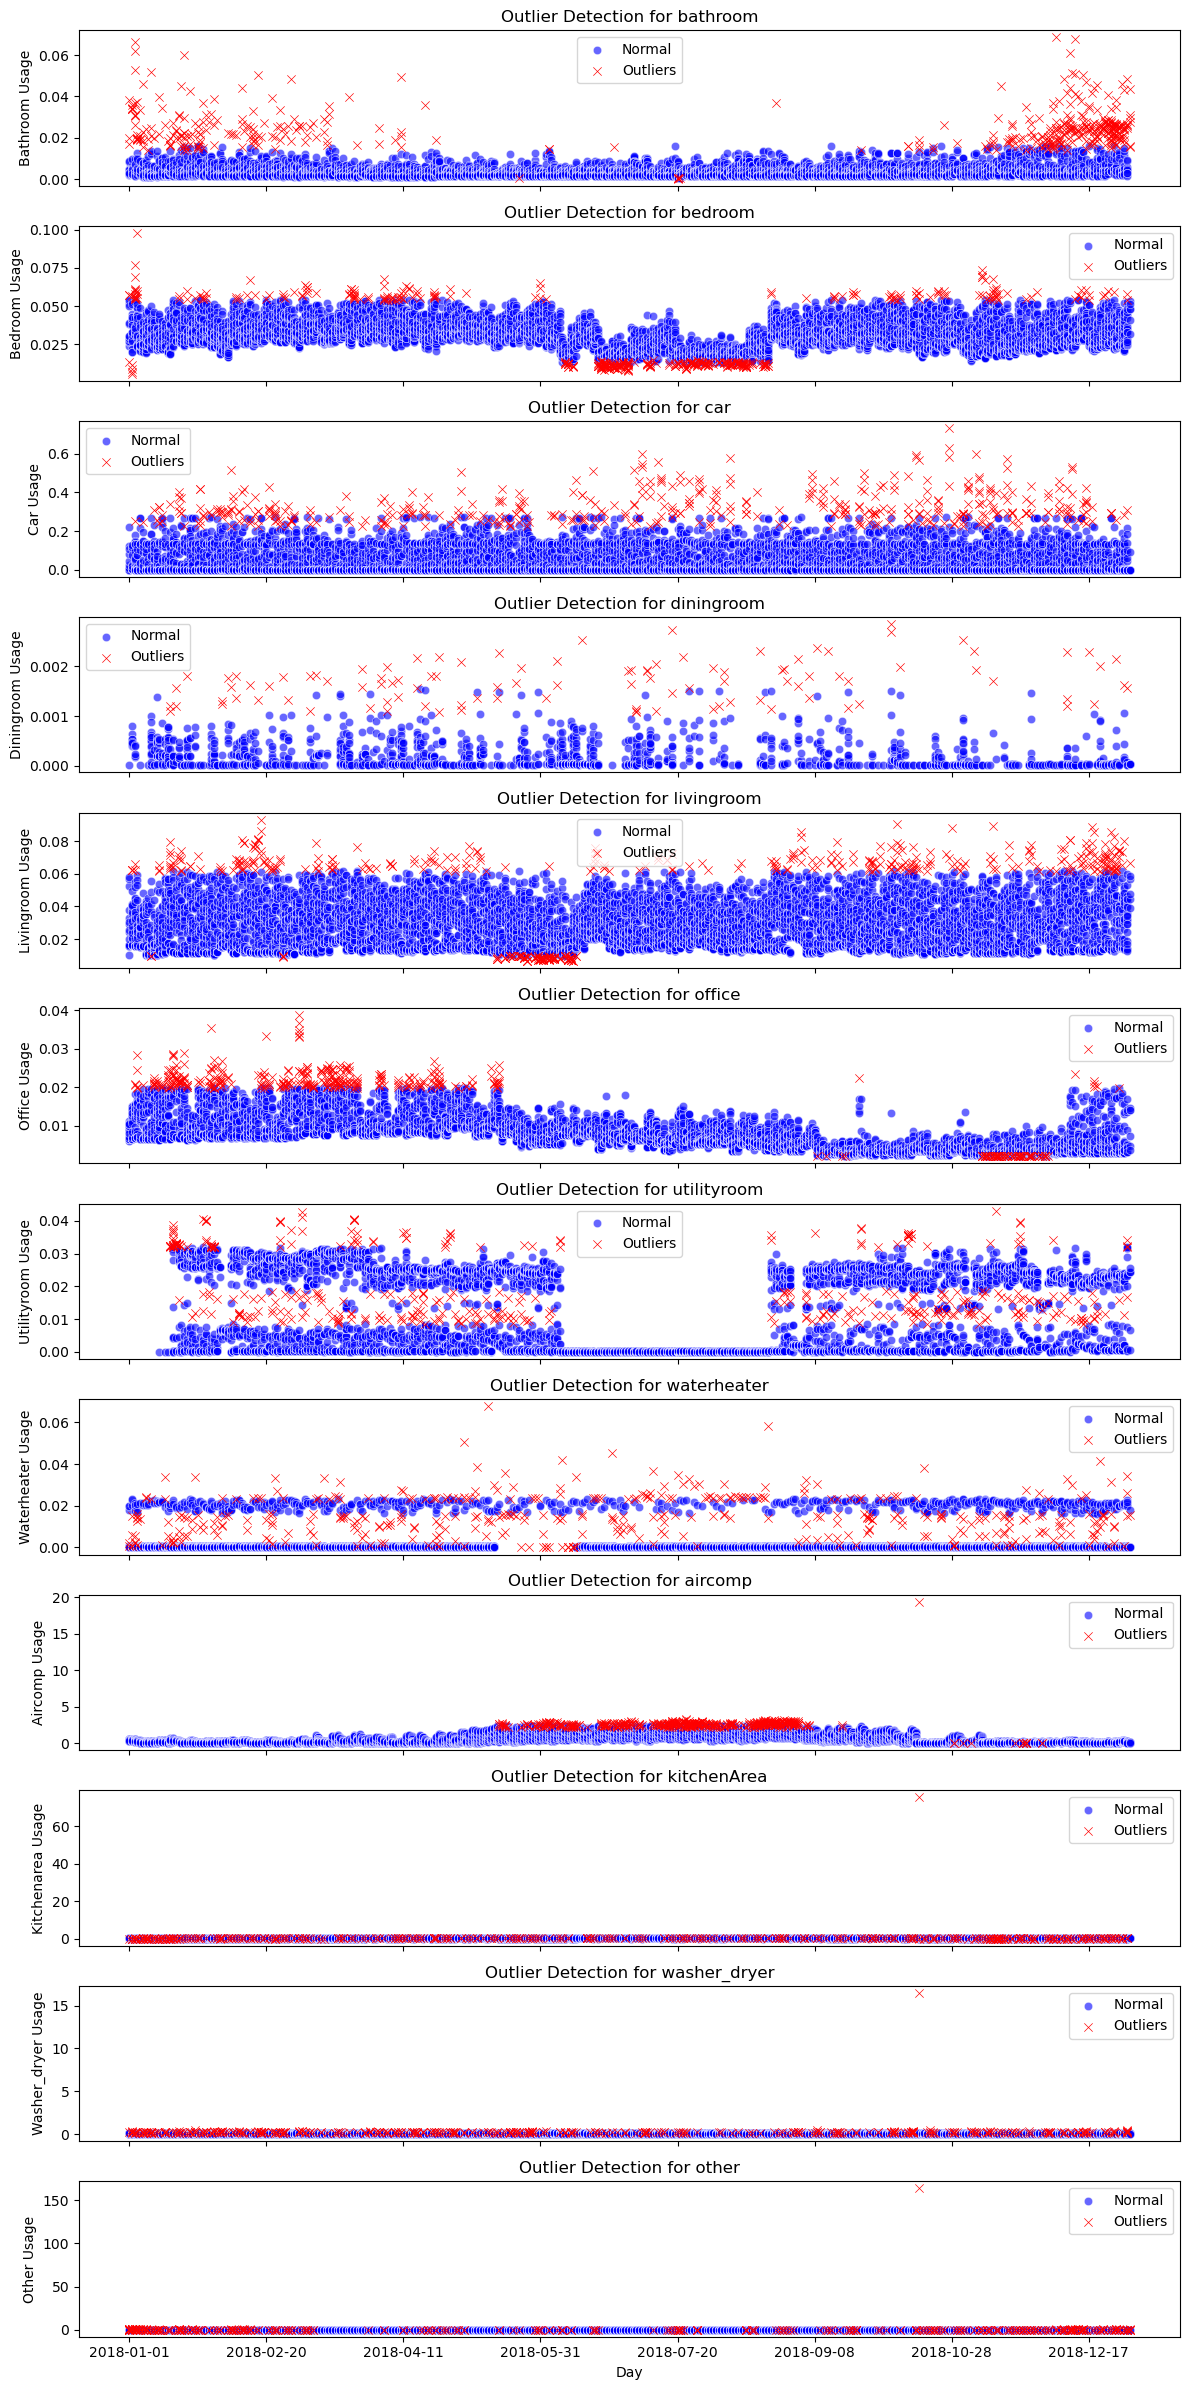

Processing outliers for city: ny


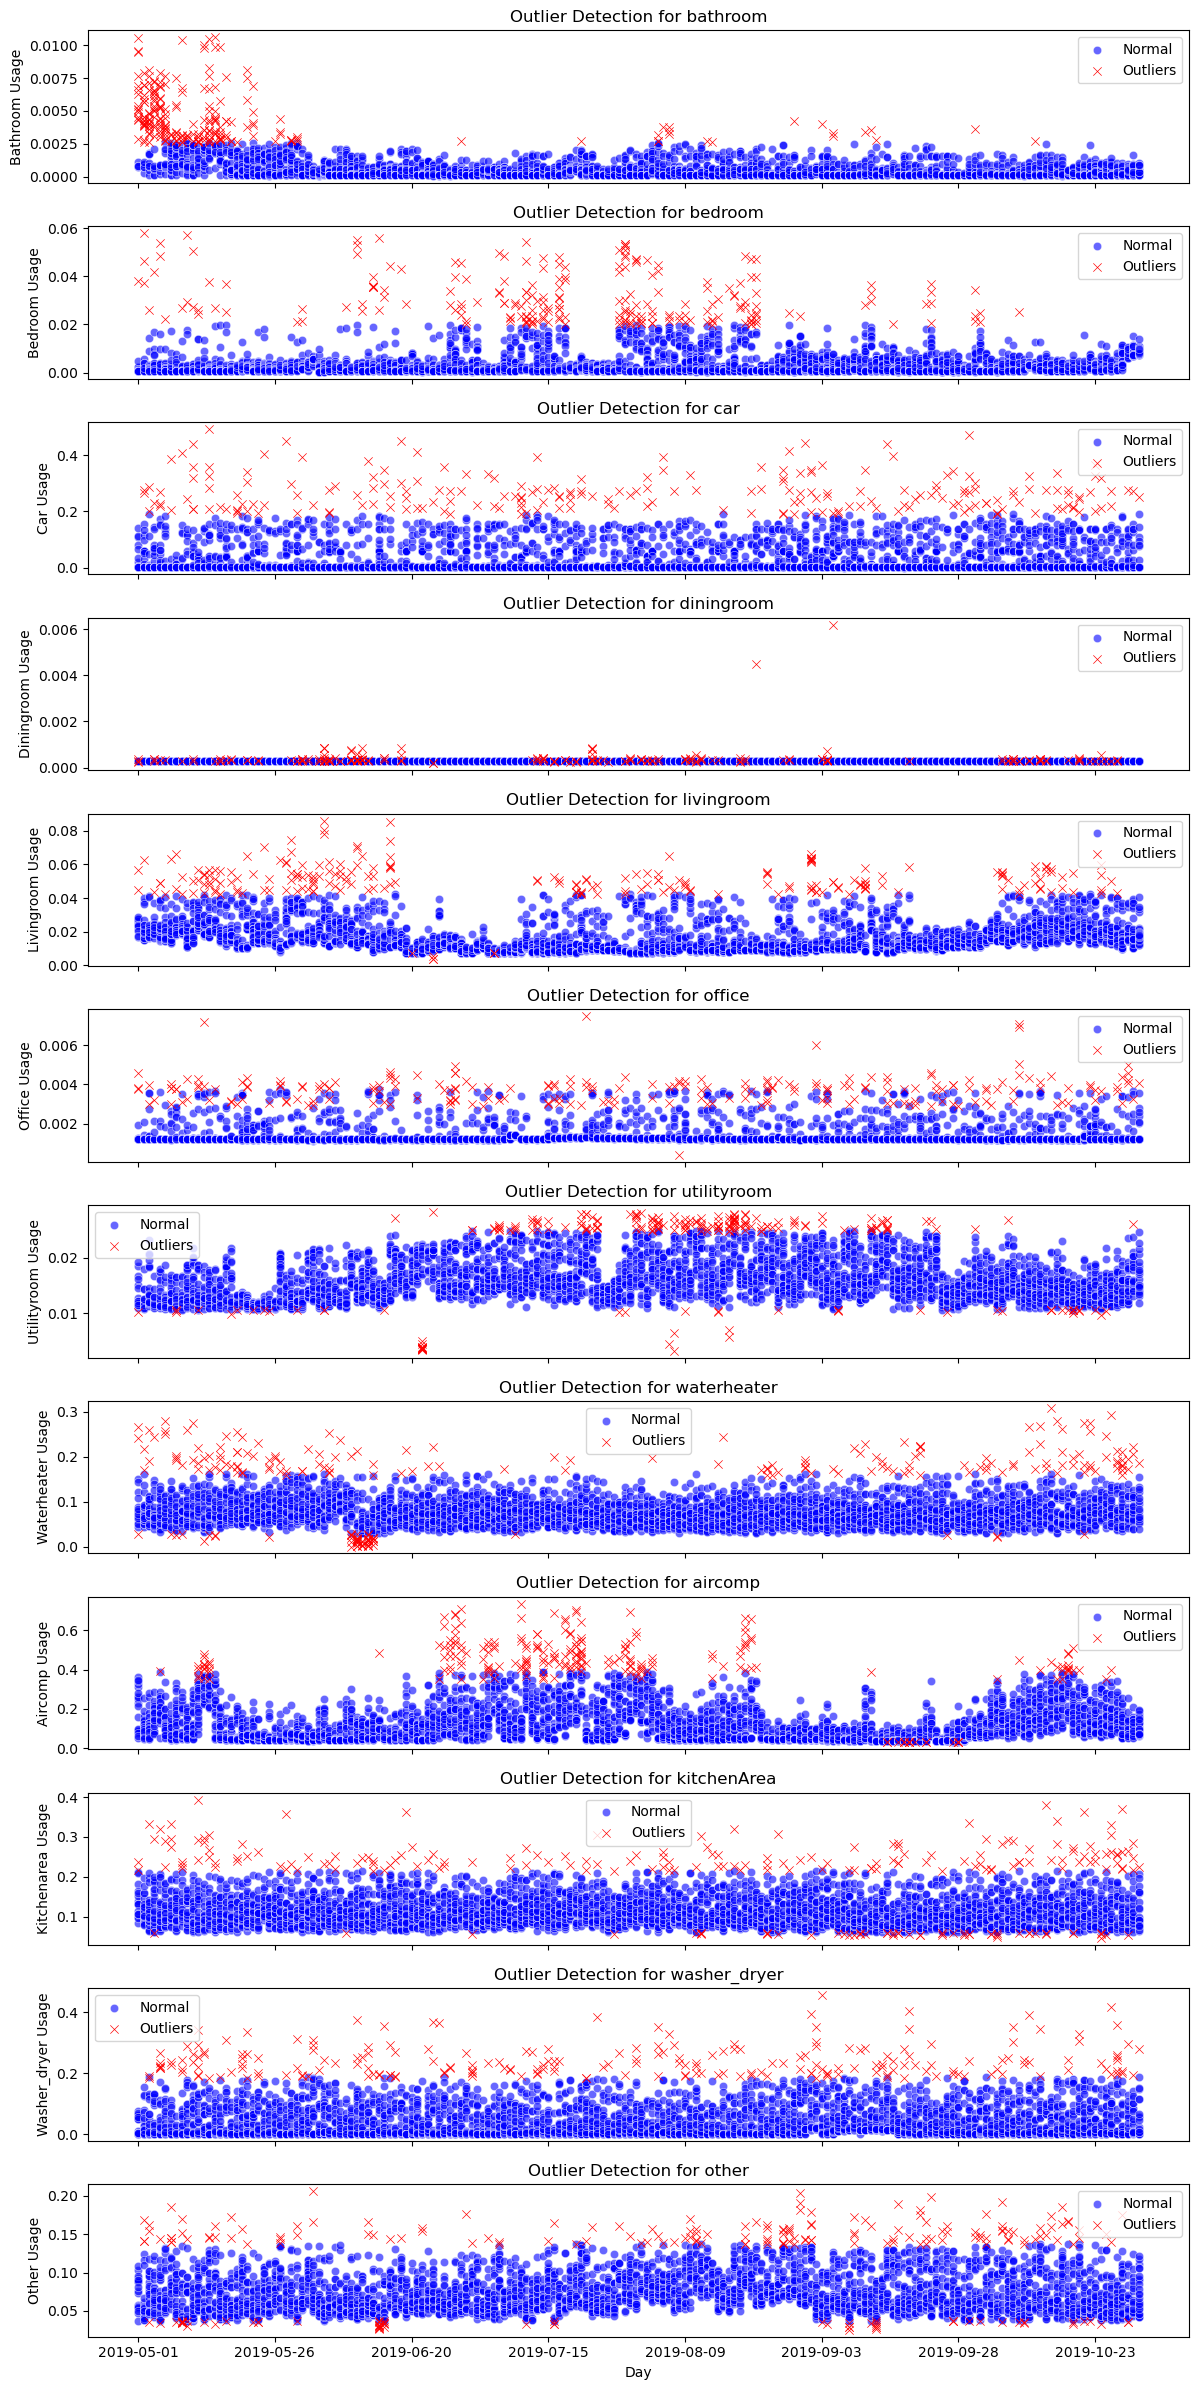

In [5]:
# Define appliance columns to analyze
appliance_cols = [
    'bathroom', 'bedroom', 'car', 'diningroom',
    'livingroom', 'office', 'utilityroom', 'waterheater', 'aircomp',
    'kitchenArea', 'washer_dryer', 'other'
]

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame()

# Loop through each city, detect outliers, and visualize them
cities = hourly_df['city'].unique()
for city in cities:
    print(f"Processing outliers for city: {city}")
    
    # Filter the DataFrame for the current city
    city_df = hourly_df[hourly_df['city'] == city].copy()
    
    # Detect outliers
    city_df = detect_outliers(city_df, appliance_cols, contamination=0.05, random_state=42)
    
    # Add city name to the DataFrame for identification
    city_df['city'] = city
    
    # Append the city's results to the results DataFrame
    results_df = pd.concat([results_df, city_df], ignore_index=True)
    
    # Visualize outliers
    visualize_outliers_multi(city_df, appliance_cols, x_axis='day')

## Combine outliers data with energy consumption

### Convert to long format

In [15]:
outlier_cols = [f"{col}_outlier" for col in appliance_cols]

# Melt the results_df for appliance usage
results_melted_usage = results_df.melt(
    id_vars=['city', 'date', 'day', 'hour'],  # Columns to retain
    value_vars=appliance_cols,  # Columns to unpivot
    var_name='appliance',  # Name of the new column for appliance names
    value_name='usage'  # Name of the new column for appliance usage
)

# Melt the results_df for appliance outliers
results_melted_outliers = results_df.melt(
    id_vars=['city', 'date', 'day', 'hour'],  # Columns to retain
    value_vars=outlier_cols,  # Columns to unpivot
    var_name='appliance_outlier',  # Name of the new column for outlier appliance names
    value_name='outlier'  # Name of the new column for outlier flags
)

# Clean the 'appliance_outlier' column to match the appliance names
results_melted_outliers['appliance'] = results_melted_outliers['appliance_outlier'].str.replace('_outlier', '')

# Merge the melted DataFrames on shared columns
results_long = pd.merge(
    results_melted_usage,
    results_melted_outliers[['city', 'date', 'day', 'hour', 'appliance', 'outlier']],
    on=['city', 'date', 'day', 'hour', 'appliance']
)

# Reorder columns to match the desired format
outlier_long = results_long[['city', 'date', 'day', 'hour', 'appliance', 'usage', 'outlier']]

# Display the restructured DataFrame
outlier_long

,city,date,day,hour,appliance,usage,outlier
0,austin,2018-01-01 06:00:00+00:00,2018-01-01,6.0,bathroom,0.019875,1.0
1,austin,2018-01-01 07:00:00+00:00,2018-01-01,7.0,bathroom,0.002219,0.0
2,austin,2018-01-01 08:00:00+00:00,2018-01-01,8.0,bathroom,0.004700,0.0
3,austin,2018-01-01 09:00:00+00:00,2018-01-01,9.0,bathroom,0.004630,0.0
4,austin,2018-01-01 10:00:00+00:00,2018-01-01,10.0,bathroom,0.004590,0.0
...,...,...,...,...,...,...,...
157195,ny,2019-10-31 19:00:00+00:00,2019-10-31,19.0,other,0.105430,0.0
157196,ny,2019-10-31 20:00:00+00:00,2019-10-31,20.0,other,0.058500,0.0
157197,ny,2019-10-31 21:00:00+00:00,2019-10-31,21.0,other,0.066900,0.0
157198,ny,2019-10-31 22:00:00+00:00,2019-10-31,22.0,other,0.071470,0.0


### Convert data to hourly -- for usability

In [16]:
# Ensure the 'date' column is datetime
df['date'] = pd.to_datetime(df['date'])

# Round the 'date' column to the nearest hour
df['date_hour'] = df['date'].dt.floor('H')

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(exclude='number').columns

# Define aggregation functions for each column
agg_dict = {col: 'mean' for col in numerical_cols}
agg_dict.update({col: 'first' for col in categorical_cols})

# Remove the duplicate `date_hour` column in the aggregation result
agg_dict.pop('date_hour', None)

# Group by the rounded hour and apply the aggregation functions
hourly_df = df.groupby('date_hour').agg(agg_dict).reset_index()

# Display the resulting DataFrame
hourly_df

/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_20259/524688691.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['date_hour'] = df['date'].dt.floor('H')


,date_hour,grid,bathroom,bedroom,car,diningroom,livingroom,office,utilityroom,waterheater,...,pres,date,day,month,day_name,time_of_day,is_weekend,season,is_holiday,city
0,2018-01-01 06:00:00+00:00,1.529774,0.019875,0.038042,0.002927,0.00000,0.029521,0.008906,0.00000,0.000948,...,1038.4,2018-01-01 06:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
1,2018-01-01 07:00:00+00:00,1.783868,0.002219,0.013792,0.002396,0.00000,0.010083,0.006063,0.00000,0.019958,...,1038.3,2018-01-01 07:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
2,2018-01-01 08:00:00+00:00,1.463260,0.004700,0.057340,0.000040,0.00000,0.016540,0.007830,0.00000,0.000400,...,1038.7,2018-01-01 08:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
3,2018-01-01 09:00:00+00:00,1.449272,0.004630,0.053610,-0.000010,0.00000,0.016580,0.009370,0.00000,0.000370,...,1039.5,2018-01-01 09:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
4,2018-01-01 10:00:00+00:00,1.443978,0.004590,0.051430,0.000050,0.00000,0.016340,0.010560,0.00000,0.000370,...,1039.9,2018-01-01 10:00:00+00:00,2018-01-01,January,Monday,Morning,False,Winter,True,austin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13095,2019-10-31 19:00:00+00:00,0.985130,0.000140,0.007640,0.190210,0.00028,0.018340,0.004090,0.01518,0.060590,...,1008.6,2019-10-31 19:00:00+00:00,2019-10-31,October,Thursday,Evening,False,Fall,False,ny
13096,2019-10-31 20:00:00+00:00,0.847460,0.000330,0.009030,0.001220,0.00028,0.040700,0.003550,0.02160,0.039600,...,1007.7,2019-10-31 20:00:00+00:00,2019-10-31,October,Thursday,Evening,False,Fall,False,ny
13097,2019-10-31 21:00:00+00:00,0.808390,0.000370,0.008350,0.002670,0.00028,0.031900,0.002020,0.01772,0.064910,...,1007.3,2019-10-31 21:00:00+00:00,2019-10-31,October,Thursday,Evening,False,Fall,False,ny
13098,2019-10-31 22:00:00+00:00,1.075560,0.000920,0.008020,0.001660,0.00028,0.033350,0.002080,0.01467,0.109020,...,1006.6,2019-10-31 22:00:00+00:00,2019-10-31,October,Thursday,Evening,False,Fall,False,ny


### reshape df (consumption data) to long format

In [17]:
# Specify the columns to keep as identifiers
id_vars = ['date', 'day', 'hour', 'month', 'time_of_day', 'is_weekend', 
           'season', 'is_holiday', 'city', 'temp', 'wspd', 'rhum', 'pres']

# Specify the appliance-related columns to melt
value_vars = ['grid', 'bathroom', 'bedroom', 'car', 'diningroom', 'livingroom', 
              'office', 'utilityroom', 'waterheater', 'aircomp', 
              'kitchenArea', 'washer_dryer', 'other']

# Reshape the DataFrame to long format
df_long = pd.melt(hourly_df, id_vars=id_vars, value_vars=value_vars, 
                  var_name='appliance', value_name='usage')

# Display the transformed DataFrame
display(df_long.head())


,date,day,hour,month,time_of_day,is_weekend,season,is_holiday,city,temp,wspd,rhum,pres,appliance,usage
0,2018-01-01 06:00:00+00:00,2018-01-01,6.0,January,Morning,False,Winter,True,austin,-2.8,9.4,78.0,1038.4,grid,1.529774
1,2018-01-01 07:00:00+00:00,2018-01-01,7.0,January,Morning,False,Winter,True,austin,-3.3,13.0,74.0,1038.3,grid,1.783868
2,2018-01-01 08:00:00+00:00,2018-01-01,8.0,January,Morning,False,Winter,True,austin,-3.3,18.4,65.0,1038.7,grid,1.463260
3,2018-01-01 09:00:00+00:00,2018-01-01,9.0,January,Morning,False,Winter,True,austin,-3.3,13.0,63.0,1039.5,grid,1.449272
4,2018-01-01 10:00:00+00:00,2018-01-01,10.0,January,Morning,False,Winter,True,austin,-3.3,14.8,63.0,1039.9,grid,1.443978


### Merge consumption (df_long) & outlier flag (outlier_long)

In [18]:
# Ensure both DataFrames have compatible columns
outlier_long['date'] = pd.to_datetime(outlier_long['date'])  # Ensure datetime format
df_long['date'] = pd.to_datetime(df_long['date'])        # Ensure datetime format

# Merge the DataFrames
merged_df = pd.merge(df_long, outlier_long[['date','city','hour','appliance','outlier']], 
                     on=['date', 'hour', 'city', 'appliance'], 
                     how='left')  # Use 'left' to preserve all rows from `grouped`

# Handle missing outlier flags (optional, e.g., mark as 0 for no flag)
merged_df['outlier'] = merged_df['outlier'].fillna(0)

# Display the merged DataFrame
display(merged_df.head())


,date,day,hour,month,time_of_day,is_weekend,season,is_holiday,city,temp,wspd,rhum,pres,appliance,usage,outlier
0,2018-01-01 06:00:00+00:00,2018-01-01,6.0,January,Morning,False,Winter,True,austin,-2.8,9.4,78.0,1038.4,grid,1.529774,0.0
1,2018-01-01 07:00:00+00:00,2018-01-01,7.0,January,Morning,False,Winter,True,austin,-3.3,13.0,74.0,1038.3,grid,1.783868,0.0
2,2018-01-01 08:00:00+00:00,2018-01-01,8.0,January,Morning,False,Winter,True,austin,-3.3,18.4,65.0,1038.7,grid,1.463260,0.0
3,2018-01-01 09:00:00+00:00,2018-01-01,9.0,January,Morning,False,Winter,True,austin,-3.3,13.0,63.0,1039.5,grid,1.449272,0.0
4,2018-01-01 10:00:00+00:00,2018-01-01,10.0,January,Morning,False,Winter,True,austin,-3.3,14.8,63.0,1039.9,grid,1.443978,0.0


### Export new dataset for Streamlit

In [20]:
# Save the restructured DataFrame
merged_df.to_csv('../data/processed/energy_data_streamlit.csv', index=False)